In [16]:
# imports

from PIL import Image
from glob import glob
import pandas as pd
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening, convex_hull_image
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pydicom
import scipy.misc
import numpy as np
import SimpleITK as sitk
from matplotlib import pyplot as plt
from tqdm import tqdm

luna_path = 'processed_data_raw/'
luna_subset_path = 'processed_data_raw/lungs_roi_npy/'
file_list=glob(luna_subset_path+"*.npy")

In [27]:
def get_segmented_lungs(im, plot=False):
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    plt_number = 0
    # Original image label: 0
    if plot:
        f, plots = plt.subplots(12, 1, figsize=(5, 40))
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(im, cmap=plt.cm.bone)
        plt_number += 1

    # Step 1: Convert into a binary image.
    # image label: 1
    binary = im < -604
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(binary, cmap=plt.cm.bone)
        plt_number += 1
    # Step 2: Remove the blobs connected to the border of the image.
    # image label: 2
    cleared = clear_border(binary)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(cleared, cmap=plt.cm.bone)
        plt_number += 1
    # Step 3: Label the image.
    # image label: 3
    label_image = label(cleared)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(label_image, cmap=plt.cm.bone)
        plt_number += 1
        
    label_image_save = label_image.copy()

    # Step 4: Keep the labels with 2 largest areas and segment two lungs.
    # image label: 4
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    labels = []
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:
                    label_image[coordinates[0], coordinates[1]] = 0
            else:
                coordinates = region.coords[0]
                labels.append(label_image[coordinates[0], coordinates[1]])
    else:
        labels = [1, 2]
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(label_image, cmap=plt.cm.bone)
        plt_number += 1
    # Step 5: Fill in the small holes inside the mask of lungs which we seperate right and left lung. r and l are symbolic and they can be actually left and right!
    # image labels: 5, 6
    
    lr_image = np.where(label_image == labels[0], 1, 0) + np.where(label_image == labels[1], 2, 0)

    r = label_image == labels[0]
    l = label_image == labels[1]
    r_edges = roberts(r)
    l_edges = roberts(l)
    r = ndi.binary_fill_holes(r_edges)
    l = ndi.binary_fill_holes(l_edges)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(r, cmap=plt.cm.bone)
        plt_number += 1

        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(l, cmap=plt.cm.bone)
        plt_number += 1

    # Step 6: convex hull of each lung
    # image labels: 7, 8
    r = convex_hull_image(r)
    l = convex_hull_image(l)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(r, cmap=plt.cm.bone)
        plt_number += 1

        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(l, cmap=plt.cm.bone)
        plt_number += 1
    # Step 7: joint two separated right and left lungs.
    # image label: 9
    sum_of_lr = r + l
    binary = sum_of_lr > 0
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(binary, cmap=plt.cm.bone)
        plt_number += 1
    # Step 8: Closure operation with a disk of radius 10. This operation is
    # to keep nodules attached to the lung wall.
    # image label: 10
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(binary, cmap=plt.cm.bone)
        plt_number += 1
    # Step 9: Superimpose the binary mask on the input image.
    # image label: 11
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot:
        plots[plt_number].axis('off')
        plots[plt_number].set_title(f'{plt_number}')
        plots[plt_number].imshow(im, cmap=plt.cm.bone)
        plt_number += 1

    return im, label_image, binary, label_image_save, lr_image

In [28]:
# imgs = []
# for file in file_list:
#     imgs.append((np.load(file), file))

# img_tuple = [(get_segmented_lungs(im), filename) for im, filename in imgs]

In [29]:
# plt.imshow(img_tuple[10][0][0], cmap=plt.cm.bone)
import cv2

# print(file_list[3])
# print(np.min(np.load(file_list[1])))
# plt.imshow(img_tuple[11][0][3])

def normalize(arr):
    """Normalize a numpy array into range [0, 255]"""
    arr_min = arr.min()
    arr_max = arr.max()
    normalized = 255 * (arr - arr_min) / (arr_max - arr_min)
    return normalized.astype(np.uint8)

def convert_binary(b):
    return (b * 255).astype(np.uint8)

import os
os.makedirs(f"{luna_path}/overlay", exist_ok=True)
os.makedirs(f"{luna_path}/label_image", exist_ok=True)
os.makedirs(f"{luna_path}/binary_image", exist_ok=True)
os.makedirs(f"{luna_path}/area_image", exist_ok=True)
os.makedirs(f"{luna_path}/lr_image", exist_ok=True)

for filename in tqdm(file_list):
    im = np.load(filename)
    im, label_image, binary, areas, lr = get_segmented_lungs(im)
    filename = filename.split('/')[-1][:-4]
    cv2.imwrite(f'{luna_path}/overlay/{filename}.png', normalize(im))
    cv2.imwrite(f'{luna_path}/label_image/{filename}.png', label_image)
    cv2.imwrite(f'{luna_path}/binary_image/{filename}.png', convert_binary(binary))
    cv2.imwrite(f'{luna_path}/area_image/{filename}.png', areas)
    cv2.imwrite(f'{luna_path}/lr_image/{filename}.png', lr)

    # Image.fromarray(im).save(f'{luna_path}overlay/{filename}.png')
    # Image.fromarray(label_image).save(f'{luna_path}label_image/{filename}.png')
    # Image.fromarray(binary).save(f'{luna_path}binary_image/{filename}.png')
    # Image.fromarray(areas).save(f'{luna_path}area_image/{filename}.png')

100%|██████████| 2217/2217 [07:05<00:00,  5.22it/s]


[98, 115]


(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int16),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0

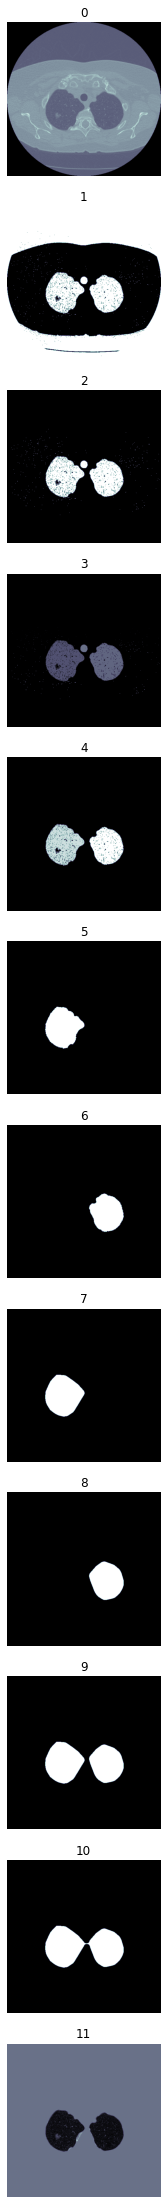

In [26]:
t = np.load("processed_data_raw/lungs_roi_npy/lungs_18_29.npy")

get_segmented_lungs(t, plot=True)